# Simple Feature Extraction Script<a class="tocSkip">
&copy; 2020 by Michael Stanley (Mike.Stanley@ieee.org)<BR>
Last revised: 25 July 2020
    
Requires presence of raw sensor data files (in the same directory as this notebook) which follow the 'log-*.csv' naming convention.  For this particular run,
the assumption is that the wildcard will map to one of 'off', 'low', 'medium' or 'high'.  There is a columns_to_drop
global list which you can use to specify columns to be dropped from raw data before features are computed.

Computed feature types include: min, max, mean, std, variance, skew factor, kurtosis and sum.  You can easily add additional features by modifying the getFeatures() function, which computes features over a user-specified range of rows from the raw data.

# Import standard Models

In [1]:
import glob
import os
import re
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR, SVC
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

# Map the "wildcard" portion of the filename to numeric class integers

In [3]:
levels = {}
levels['off']=0
levels['low']=1
levels['medium']=2
levels['high']=3

The process of gathering and converting raw sensor data files to a single .csv file that can be used for training is outlined in the figure below.  Generic classes C0-C3 correspond to 'off' through 'high' respectively. 
![Feature Extraction Process](../images/FeatureComputation.png)  
Raw Data Files (A) correspond to:
* log-off.csv
* log-low.csv
* log-medium.csv
* log-high.csv

Each of (A) are partitioned into blocks that are inc=10 samples long.  Each sample block is converted to one row of features and these are rolled into feature tables (B) above, where each table corresponds to the features extracted for one of the raw data files.  (B) are then appended into a single consolidated feature data file (C).

There is nothing magical about the choice of inc=10.  It simply corresponds to one seconds worth of data from our data logger application.  This will have a direct bearing on the latency of the final computed model.

# Get Started:
* Specify what columns of the original data files to drop before computing features.  This choice is usually based upon some understanding of the physics involved.  Or you may just start with an empy list and add items as you find they are not needed.
* glob the local directory for 'log-*.csv'.  
* Finally, print the column names from the first files found as a visual verification

In [4]:
columns_to_drop=['Index', 'rH', 'pressure', 'temp', 'proximity', 
'accelX', 'accelY', 'accelZ', 'magX', 'magY', 'magZ', 'gyroX', 'gyroY', 'gyroZ']

# Use a glob function to search for log files in the current directory.
files = glob.glob('log-*.csv')

d = pd.read_csv(files[0], skipinitialspace=True)
print('Data files contain the following columns:')
for c in d.columns:
    print(c)

Data files contain the following columns:
Index
accelX
accelY
accelZ
magX
magY
magZ
gyroX
gyroY
gyroZ
temp
rH
pressure
proximity
maxAudio


# Compute standard DataFrame functions
This function computes values over a range of rows and renames the labels to include both sensor and feature type in the
data labels.

In [5]:
def compute(d, func, funcName):
    vals = func()
    vals = vals.to_frame().transpose()
    vals.columns = vals.columns+'_'+funcName
    return vals

# getFeatures()
Computes some of the standard Panda dataframe column-based statistics.  Because we call compute multiple times (each of which computes a metric over the full range of data columns), we will need to do a "join" operation to create a long data row which contains all the new values.

In [6]:
def getFeatures(d):
    vals = compute(d, d.max, 'max')
    vals = vals.join(compute(d, d.min, 'min'))
    vals = vals.join(compute(d, d.skew, 'skew'))
    vals = vals.join(compute(d, d.kurtosis, 'kurtosis'))
    vals = vals.join(compute(d, d.sum, 'sum'))
    vals = vals.join(compute(d, d.mean, 'mean'))
    vals = vals.join(compute(d, d.std, 'std'))  # This is the sample standard deviation (STDEV.S in Excel)
    vals = vals.join(compute(d, d.var, 'var'))
    return vals

# extract()
Calls the getFeatures repeatedly and builds the features table row by row.

In [7]:
def extract(d, inc):
    rows, cols = d.shape
    first = True
    for r in range(0, rows, inc):
        subd = d[r: r+inc-1]
        fnew=getFeatures(subd)
        if first:
            features=fnew
            first=False
        else:
            features = features.append(fnew)
    return(features)

# load_and_extract()
Reads a .csv file, computes vector magnitudes for triaxial sensors, builds the feature table by calling extract() 
and builds
a matching result dataframe.  This corresponds to the process of converting (A) to (B) in the earlier figure.

In [8]:
def load_and_extract(fn, inc):
    global columns_to_drops_to_drop
    print('Processing: ', fn)
    f = fn.replace('.','-')
    _, state, _ = f.split('-')
    # Read the data file
    d = pd.read_csv(fn, skipinitialspace=True)
    # Compute vector magnitudes of tri-axis sensors
    d['acc'] = np.sqrt(d['accelX']*d['accelX']+d['accelY']*d['accelY']+d['accelZ']*d['accelZ'])
    d['mag'] = np.sqrt(d['magX']*d['magX']+d['magY']*d['magY']+d['magZ']*d['magZ'])
    d['gyro'] = np.sqrt(d['gyroX']*d['gyroX']+d['gyroY']*d['gyroY']+d['gyroZ']*d['gyroZ'])
    # drop unwanted columns.
    for c in columns_to_drop:
        d=d.drop(labels=[c], axis=1)
    features = extract(d, inc)
    rows, cols = features.shape
    results = pd.Series(rows * [levels[state]], index=np.arange(0, rows, 1), name='class').to_frame()
    return features, results

# Top level loop
This function loops over the globbed file list, computing feature & results tables for each, and then appending those all togeether into two files that represent all features and all class assignments respectively.  Then do a bit of cleanup on the pandas datatable indices.  Finally merge the features and results tables into one table that can be written to a single .csv file.

In [9]:
first = True
for fn in files:
    f, r = load_and_extract(fn, 10)
    if first:
        features = f
        results = r
        first = False
    else:
        features = features.append(f)
        results = results.append(r)
print('Features computed include:', features.columns)

# Fix the indices
rows, cols = features.shape
keys=np.arange(rows)
features.set_index(keys=keys, inplace=True)
results.set_index(keys=keys, inplace=True)
print('Features shape=', str(features.shape))

# Merge the two tables, also drop any rows containing a "na" value.
data = features.join(results, how='inner', sort=False)
data = data.dropna(how='any', inplace=False)
data

Processing:  log-high.csv
Processing:  log-low.csv
Processing:  log-medium.csv
Processing:  log-off.csv
Features computed include: Index(['maxAudio_max', 'acc_max', 'mag_max', 'gyro_max', 'maxAudio_min',
       'acc_min', 'mag_min', 'gyro_min', 'maxAudio_skew', 'acc_skew',
       'mag_skew', 'gyro_skew', 'maxAudio_kurtosis', 'acc_kurtosis',
       'mag_kurtosis', 'gyro_kurtosis', 'maxAudio_sum', 'acc_sum', 'mag_sum',
       'gyro_sum', 'maxAudio_mean', 'acc_mean', 'mag_mean', 'gyro_mean',
       'maxAudio_std', 'acc_std', 'mag_std', 'gyro_std', 'maxAudio_var',
       'acc_var', 'mag_var', 'gyro_var'],
      dtype='object')
Features shape= (265, 32)


,maxAudio_max,acc_max,mag_max,gyro_max,maxAudio_min,acc_min,mag_min,gyro_min,maxAudio_skew,acc_skew,...,gyro_mean,maxAudio_std,acc_std,mag_std,gyro_std,maxAudio_var,acc_var,mag_var,gyro_var,class
0,410.0,1.083094,195.772846,5.073155,273.0,0.923016,57.546733,4.294951,-0.344055,0.518716,...,4.588854,48.376130,0.058315,48.844890,0.238938,2340.250000,3.400600e-03,2385.823247,0.057091,3
1,425.0,1.085047,140.456970,4.926145,224.0,0.924782,53.430443,4.368535,-0.294781,-0.245267,...,4.641632,72.525857,0.058639,27.693879,0.186115,5260.000000,3.438589e-03,766.950919,0.034639,3
2,370.0,1.076098,199.309033,5.045434,220.0,0.916053,62.945978,4.383207,-1.198042,-0.217548,...,4.670256,49.792068,0.057537,48.182975,0.220392,2479.250000,3.310495e-03,2321.599033,0.048573,3
3,357.0,1.089159,197.883846,4.994006,231.0,0.918212,56.329156,4.310742,-0.994493,0.395041,...,4.682619,39.446166,0.059340,55.441531,0.182536,1556.000000,3.521254e-03,3073.763414,0.033319,3
4,466.0,1.102162,130.866103,4.995088,278.0,0.927438,53.733718,4.325610,1.022914,0.233299,...,4.607839,55.816913,0.059459,25.057020,0.246375,3115.527778,3.535340e-03,627.854240,0.060701,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,53.0,1.001125,77.894178,4.790699,16.0,0.998844,77.192430,4.580044,0.230816,1.243092,...,4.691269,12.673244,0.000728,0.215566,0.081216,160.611111,5.298034e-07,0.046469,0.006596,0
260,225.0,0.999810,78.019652,4.813689,39.0,0.998642,76.887119,4.485766,2.363253,0.297388,...,4.636686,59.143892,0.000381,0.373034,0.111463,3498.000000,1.448704e-07,0.139155,0.012424,0
261,63.0,0.999740,77.578775,4.860206,0.0,0.998154,76.863512,4.567975,0.964790,1.351753,...,4.743183,20.730412,0.000537,0.249030,0.078781,429.750000,2.888992e-07,0.062016,0.006206,0
262,53.0,0.999810,78.475339,4.977791,13.0,0.998844,77.079372,4.498455,-0.846808,-0.847247,...,4.723630,12.429803,0.000444,0.393531,0.174677,154.500000,1.974028e-07,0.154867,0.030512,0


# Subroutine for XY plots: myScatterPandas()
This utility function can create an XY plot of any two features found in the final table.  This function works on Pandas dataframes.

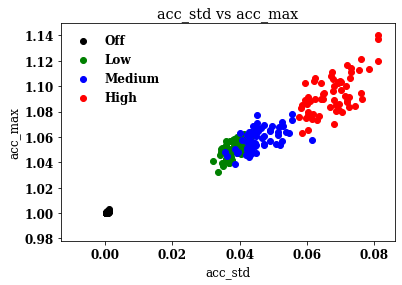

In [10]:
def myScatterPandas(data, f1, f2, C=None):
    labels=['Off', 'Low', 'Medium', 'High']
    color = ['black', 'green', 'blue', 'red']
    fig, ax = plt.subplots()
    x0 = data[f1].to_numpy()
    x1 = data[f2].to_numpy()
    if not (type(C)==pd.core.series.Series):
        C=data['class'].astype(int)
    for g in np.unique(C):
        ix = np.where(C==g)
        c=color[g]
        ax.scatter(x0[ix], x1[ix], c=c, label=labels[g])
    plt.title(f1 + ' vs ' + f2)
    plt.legend(loc='best', frameon=False, labels=['Off', 'Low', 'Medium', 'High'])
    plt.xlabel(f1)
    plt.ylabel(f2)
myScatterPandas(data, 'acc_std', 'acc_max')

# Save .csv
Save the final table (containing both features and known class memberships) to a .csv file.  This can be read by any
spreadsheet or other python script.

In [11]:
fn = 'features.csv'
headerLine=''
for c in data.columns:
    headerLine+=c
    if c!='class':
        headerLine+= ','

with open(fn, 'w') as f:
    np.savetxt(f, data, delimiter=',', header=headerLine, fmt='%6.5e', comments='')

# Reimport and quick visual check of saved data
Load the newly generated .csv file back into memory and replot.  This should visually match the plot above.
Note that unit testing shows one line of the original data has been dropped for some reason.  This is considered
acceptable.

<class 'pandas.core.frame.DataFrame'>
Recovered data file shape is:  (262, 33)


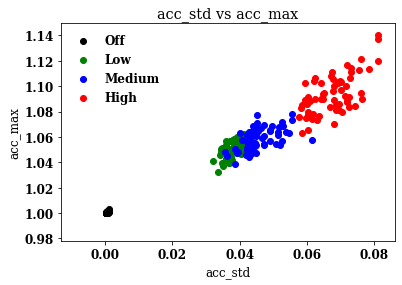

In [12]:
import csv
fn = 'features.csv'
data2 = pd.read_csv(fn)
print(type(data2))
print('Recovered data file shape is: ', str(data2.shape))

results2=data2['class'].astype(int)
features2=data2.drop(labels=['class'], axis=1)

myScatterPandas(data2, 'acc_std', 'acc_max')